This Notebook is for Problem 6

Market Segmentation

In [3]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np


In [4]:
marketSegmentation = pd.read_csv('social_marketing.csv')

chatter_IQR = marketSegmentation['chatter'].quantile(0.75) - marketSegmentation['chatter'].quantile(0.25)
chatter_75th = marketSegmentation['chatter'].quantile(0.75)

marketSegmentation = marketSegmentation[(marketSegmentation['spam'] == 0) &
                                        (marketSegmentation['chatter'] < (chatter_IQR * 1.5 + chatter_75th))]

marketSegmentation = marketSegmentation.drop(columns=['spam'])


In [7]:
# standardize data
marketSegmentationScale = StandardScaler().fit_transform(marketSegmentation.drop(columns=['Unnamed: 0']))


In [13]:
# PCA
pca = PCA()
pcaMarketSegmentationResult = pca.fit_transform(marketSegmentationScale)

# calculate variance
varianceExplained = pca.explained_variance_
percentageVarianceExplained = varianceExplained / varianceExplained.sum() * 100
cumulativePercentageVarianceExplained = np.cumsum(percentageVarianceExplained)

# cumulative variance
print(cumulativePercentageVarianceExplained)

# number of components 95% variance
print(np.sum(cumulativePercentageVarianceExplained < 95))

# first 28 principal components
pcaMarketSegmentation = pcaMarketSegmentationResult[:, :28]


[ 12.70743291  20.97333918  28.26167987  34.99160995  41.21696589
  46.25341316  50.98743917  55.08046954  58.3463205   61.35465738
  64.25042947  66.94652701  69.60397835  72.17059853  74.65945221
  77.06431189  79.36763081  81.44047043  83.29329675  84.89691526
  86.29987302  87.65254189  88.98663654  90.19216566  91.38247807
  92.55296364  93.70335254  94.76848531  95.78522534  96.77998007
  97.64086721  98.30835087  98.95064795  99.49715914 100.        ]
28


In [17]:
# t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsneResult = tsne.fit_transform(pcaMarketSegmentation)

# t-SNE datframe
tsneData = pd.DataFrame({
    'X': marketSegmentation['Unnamed: 0'],
    'TSNE_1': tsneResult[:, 0],
    'TSNE_2': tsneResult[:, 1]
})


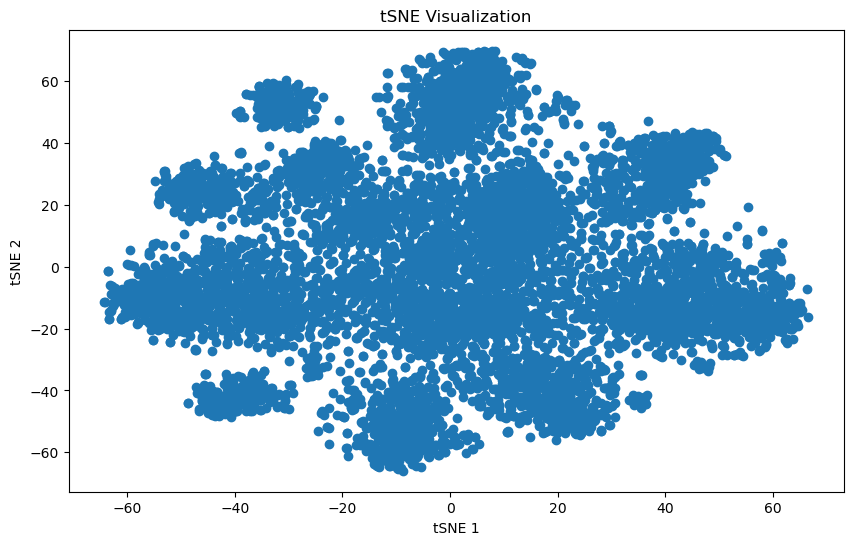

In [19]:
# Plot t-SNE
plt.figure(figsize=(10, 6))
plt.scatter(tsneData['TSNE_1'], tsneData['TSNE_2'])
plt.title('tSNE Visualization')
plt.xlabel('tSNE 1')
plt.ylabel('tSNE 2')
plt.show()


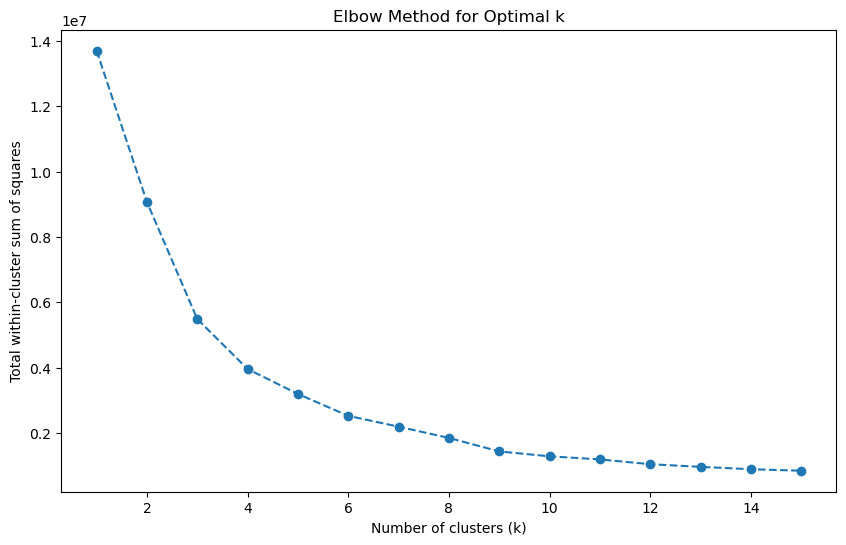

In [23]:
# elbow method 
wss = []
for k in range(1, 16):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(tsneData[['TSNE_1', 'TSNE_2']])
    wss.append(kmeans.inertia_)

# plot elbow method
plt.figure(figsize=(10, 6))
plt.plot(range(1, 16), wss, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Total within-cluster sum of squares')
plt.show()


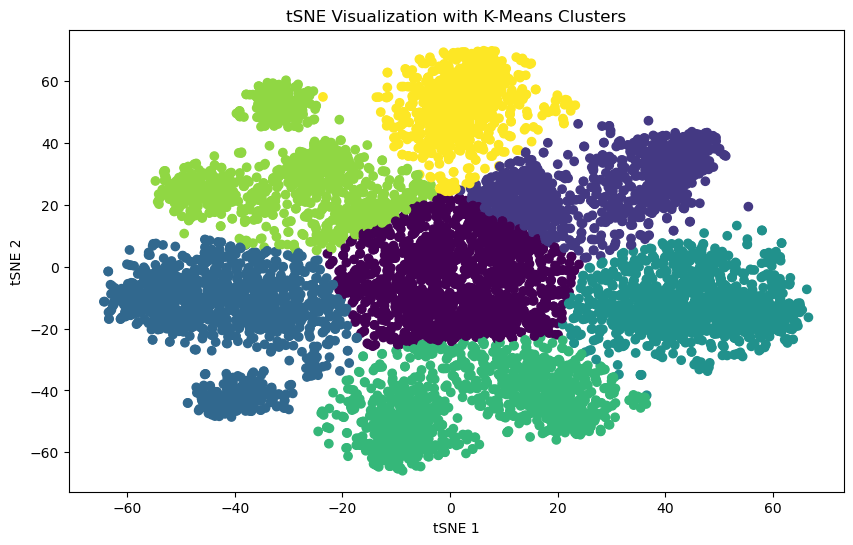

In [25]:
#  K-Means Clustering 
optimalK = 7
kmeans = KMeans(n_clusters=optimalK, n_init=20, random_state=42)
kmeansTSNEResult = kmeans.fit_predict(tsneData[['TSNE_1', 'TSNE_2']])
tsneData['cluster'] = kmeansTSNEResult

# plot t-SNE
plt.figure(figsize=(10, 6))
plt.scatter(tsneData['TSNE_1'], tsneData['TSNE_2'], c=tsneData['cluster'], cmap='viridis')
plt.title('tSNE Visualization with K-Means Clusters')
plt.xlabel('tSNE 1')
plt.ylabel('tSNE 2')
plt.show()


In [29]:
# Merge clusters with the original data
marketSegmentationClustered = marketSegmentation.merge(tsneData[['X', 'cluster']], left_on='Unnamed: 0', right_on='X')

# Filter numeric columns before grouping and summarizing
numeric_columns = marketSegmentationClustered.select_dtypes(include=[np.number]).columns

# Group by cluster and calculate the median for numeric columns only
clusterProfiles = marketSegmentationClustered.groupby('cluster')[numeric_columns].median()

# Display the cluster profiles
print(clusterProfiles)

         chatter  current_events  travel  photo_sharing  uncategorized  \
cluster                                                                  
0            3.0             1.0     1.0            1.0            0.0   
1            5.0             1.0     1.0            3.0            0.0   
2            3.0             1.0     1.0            1.0            1.0   
3            3.0             1.0     1.0            1.0            0.0   
4            3.0             1.0     2.0            1.0            0.0   
5            4.0             1.0     1.0            2.0            1.0   
6            3.0             1.0     1.0            4.0            1.0   

         tv_film  sports_fandom  politics  food  family  ...  religion  \
cluster                                                  ...             
0            0.0            0.0       0.0   0.0     0.0  ...       0.0   
1            1.0            1.0       1.0   1.0     1.0  ...       0.0   
2            0.0            1.0      

The analysis of NutrientH20's social media audience revealed seven distinct market segments identified using t-SNE visualization and K-means clustering with a k value of seven.

Cluster 0 consists of low-activity users who show minimal engagement across all categories. This group represents a more passive portion of the audience, suggesting that they may require more engaging content or different strategies to increase interaction with the brand.

Cluster 1 includes users with balanced engagement across several categories, though they do not exhibit a strong focus on any particular area. These users demonstrate moderate interest in activities like photo sharing and family-related content, indicating that varied content touching on multiple aspects of life, such as health and leisure, could resonate well with them.

Cluster 2 is made up of health-conscious users who exhibit a strong focus on personal fitness. This group is highly engaged in fitness activities, suggesting that targeted marketing with health-related products, fitness challenges, or collaborations with fitness influencers would be particularly effective.

Cluster 3 encompasses family-oriented users and sports enthusiasts. This segment is characterized by a strong interest in sports, family, religion, and parenting. Content that emphasizes family values, sports events, or community activities is likely to appeal to this group.

Cluster 4 includes users who are particularly politically active, showing a distinct interest in political content. This group may be more receptive to campaigns that align with social causes or political movements, offering an opportunity to engage them through cause-related marketing.

Cluster 5 is primarily mainly entrepreneurs and small business owners who are active in small business-related content. Offering business-related content tailored to entrepreneurs could effectively capture the interest of this segment.

Cluster 6 consists of users who focus heavily on fashion, beauty, and personal appearance. This segment is likely to respond well to targeted marketing of fashion and beauty products, lifestyle tips, or collaborations with fashion influencers.

In conclusion, the segmentation analysis has identified several key market segments within NutrientH20's social media audience. Each segment presents unique opportunities for marketing strategies that can drive brand growth in specific demographics. Tailoring content to the interests of these segments, NutrientH20 can more effectively connect with its audience.